In [136]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import log_loss
from sklearn.decomposition import PCA

random_state = 10 # Ensure reproducible results
%matplotlib inline

In [137]:
#------------DATA and TRAIN VALIDATION TEST SPLIT-----------------
ing_mat = loadmat('MATLAB/ingredients.mat')['ingredients']
# cityDist_mat = loadmat('MATLAB/citiesDistMat.mat')['citiesDistMat']
labelName_mat = loadmat('MATLAB/labelNames.mat')['labelNames']
labels_mat = loadmat('MATLAB/labels.mat')['labels']
recipe_mat = loadmat('MATLAB/recipes.mat')['recipes']
ing_headline = []
for i in ing_mat[0]:
    ing_headline.append(i[0])
dataset_X = pd.DataFrame(recipe_mat,columns=ing_headline)
dataset_y = pd.DataFrame(labels_mat,columns=['label'])
X_train_full,X_test,y_train_full,y_test = train_test_split(dataset_X,dataset_y,test_size=0.2)
X_train,X_val,y_train,y_val = train_test_split(X_train_full,y_train_full,test_size=0.25)
X_train_len = len(X_train)

In [138]:
#--- additionally have cuisines as list
cuisines = []
for n in range(0, 12, 1):
    idx = dataset_y.index[dataset_y.label == n+1]
    cuisines.append(labelName_mat[idx[0]][0].item())

# Exploratory Data Analysis

## Plots

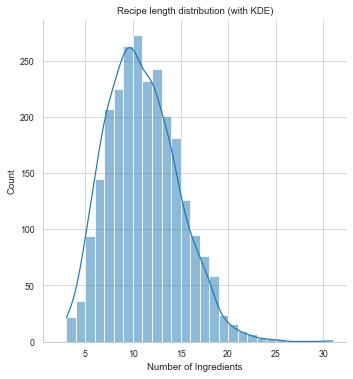

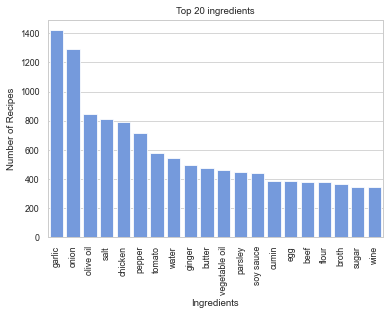

In [139]:
#------------EXPLORATORY DATA ANALYSIS-----------------

## Diagrams
## -- Plot number of ingredients
sns.set_context('paper')
sns.set_style("whitegrid")
ax = sns.displot(np.sum(X_train,axis=1), bins=np.linspace(1,29,29)+1,kde=True)
ax.set(xlabel="Number of Ingredients", title="Recipe length distribution (with KDE)")
# ax.savefig("./Figures/Recipe_length.png", dpi=500) ## Save the figure produced

##--- top 20 most used ingredients
fig, ax = plt.subplots()
# sum up occurences of each ingredient and
# filter for the 20 most frequent
most_freq_ing = X_train.sum().nlargest(20)
ax = sns.barplot(x=most_freq_ing.index, y=most_freq_ing.values, color='cornflowerblue')
ax.set(xlabel="Ingredients", ylabel="Number of Recipes", title="Top 20 ingredients")
xticks = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# ax.figure.savefig("./Figures/Top_20.png", dpi=500) ## Save the figure produced

<AxesSubplot:>

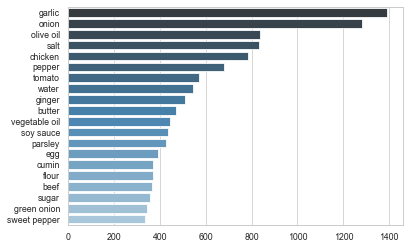

In [8]:
## 2nd Version of barplot, with vertical orientation
sns.set_palette(reversed(sns.color_palette("Blues_d", 20)),20)
sns.barplot(y=most_freq_ing.index,x=most_freq_ing.values)

## Tables

### Number of ingredients per cuisine

In [146]:
## Tables
## number changes due to the randomness of the split...
used_ing = []
for n in range(0, 12, 1):
    idx = y_train.index[y_train.label == n+1] # find number of recipes per label
    freq_ing_cuis = X_train.loc[idx].sum() # find ingredients in the recipes per label
    used_idx = freq_ing_cuis.index[freq_ing_cuis != 0] 
    used_ing.append(len(used_idx)) # append total ingredients

data_ing = pd.DataFrame(data = {"Cuisine": cuisines, 
                    "#Ingredients Used": used_ing})

data_ing.sort_values(by="#Ingredients Used", ascending=False)

## might be better to use original dataset as follows:

# used_ing = []
# for n in range(0, 12, 1):
#     idx = dataset_y.index[dataset_y.label == n+1]
#     freq_ing_cuis = dataset_X.iloc[idx].sum()
#     used_idx = freq_ing_cuis.index[freq_ing_cuis != 0]
#     used_ing.append(len(used_idx))

# data_ing = pd.DataFrame(data = {"Cuisine": cuisines, 
#                     "#Used ingredients": used_ing})

# data_ing.sort_values(by="#Used ingredients", ascending=False)

,Cuisine,#Ingredients Used
1,English,267
2,French,248
10,Spanish,232
7,Japanese,226
11,Thai,222
8,Mexican,219
9,Moroccan,213
3,German,210
4,Greek,210
6,Italian,209


In [7]:
#------------DIMENSIONALITY REDUCTION-----------------

## PCA


## tSNE


## ISOMAP


## UMAP



In [8]:
#------------MODELS-----------------------------------

## Logistic Regression


## Naive Bayes


## Logistic Regression DR


## Naive Bayes DR


## Other 1


## Other 2


## Other 3

In [10]:
#------------VALIDATION-------------------------------

## BEST MODEL Hyperparameter tuning

## Final Model



In [ ]:
#------------TEST SET PREDICTIONS---------------------

## Accuracy scores

## MISC

